In [1]:
import matplotlib.pyplot as plt
import re
import pandas as pd
import os
import numpy as np

In [2]:
import seaborn as sns

In [3]:
%matplotlib widget

# List of model sizes

In [4]:
def gpt_parameter_count(
    num_layers,
    hidden_size,
    vocab_size, 
    sequence_length,
    attention_head_type,
    num_heads=None,
    return_in_M=True
):
    """
    Returns the number of parameters for a decoder-only transformer assuming a 4x feedforward ratio.
    - MLP (h->4h->h):  8 * h*h + 5 * h
    - MHA Attention (KQV + h->h): 3 * h*h + 3 * h + h*h + h
    - LayerNorm (input+post_attention): 4 * h
    - Embeddings (vocab and positional): V * h + s * h
    Total: 12 * L * h*h + 13 * L * h + (V+s) * h
    
    For MQA, Attention becomes: h*h + h + 2 * h*head_dim + 2 * head_dim + h*h + h
    delta = -2 * h*h -2 * h + 2 * h*head_dim + 2 * head_dim
    Total: 10 * L * h*h + 2 * L * h*head_dim + 11 * L * h + 2 * L * head_dim + (V+s) * h
    """
    if attention_head_type == "multihead":
        param_count = 12 * num_layers * (hidden_size*hidden_size)
        param_count += 13 * num_layers * hidden_size
        param_count += (vocab_size + sequence_length) * hidden_size
    elif attention_head_type == "multiquery":
        assert num_heads is not None, "Number of parameters depends on the number of heads for MQA"
        assert hidden_size % num_heads == 0
        head_dim = hidden_size / num_heads
        param_count = 10 * num_layers * (hidden_size*hidden_size) + 2 * num_layers * hidden_size * head_dim
        param_count += 11 * num_layers * hidden_size + 2 * num_layers * head_dim
        param_count += (vocab_size + sequence_length) * hidden_size
        
    else:
        raise ValueError(f"Unrecognized attention head type: {attention_head_type}")
    
    if return_in_M:
        return param_count * 1e-6
    else:
        return param_count
    

Let's check that the number of parameters output by our function are coherent with what is obtained when running Megatron

In [5]:
# 350M model.
# Vocab padded to 50048
# Megatron reports: 355657728 parameters
gpt_parameter_count(24, 1024, 50048, 2048, "multihead")

355.65567999999996

In [6]:
# 1B model (MHA)
# Megatron report: 1313722368 params
gpt_parameter_count(24, 2048, 49280, 2048, "multihead")

1313.7182719999998

In [7]:
# 1B model (MQA)
# Megatron reports: 1124886528 params
gpt_parameter_count(24, 2048, 49280, 2048, "multiquery", num_heads=16)

1124.8824319999999

There seems to be a (2 * hidden_size) term missing from our function?

In [8]:
# This list is heavily inspired by the list of architectures used in Chinchilla
# layer, hidden_size, num_heads
model_list = [
    [2, 2*64, 2], # 7M
    [4, 3*64, 3], # 11M
    [4, 256, 4],
    [6, 384, 6],
    [8, 512, 8], # 48M
    [10, 640, 10], # 75M
    [12, 768, 12], # 108M
    [20, 768, 12], # 160M
    [20, 896, 14], # 209
    [22, 1024, 16], # 306
    [22, 1280, 10], # 425
    [22, 1536, 12],
    [24, 1792, 14],
    [24, 2048, 16], # 1.1B
    [26, 2304, 18],
    [30, 2560, 20],
    [36, 2816, 22],
    [40, 3584, 28],  # 5.3B
    [42, 4096, 32],  # 
]

df = pd.DataFrame(model_list, columns = ["num_layer", "hidden_size", "num_heads"])

In [9]:
df["param_count"] = [
    gpt_parameter_count(num_layer, hidden_size, 49280, 2048, "multiquery", num_heads)
    for (num_layer, hidden_size, num_heads) in model_list
]

In [10]:
for idx, row in df.iterrows():
    (num_layer, hidden_size, num_heads, param_count) = list(row)
    # param_count = gpt_parameter_count(num_layer, hidden_size, 49280, 2048, "multihead", num_heads)
    # print(f"MHA {num_layer} layers, {hidden_size} hidden_size, {num_heads} heads: {param_count}")
    param_count = gpt_parameter_count(num_layer, hidden_size, 49280, 2048, "multiquery", num_heads)
    print(f"MQA {num_layer:3.0f} layers, {hidden_size:5.0f} hidden_size, {num_heads:3.0f} heads: {param_count:6.1f}")

MQA   2 layers,   128 hidden_size,   2 heads:    6.9
MQA   4 layers,   192 hidden_size,   3 heads:   11.4
MQA   4 layers,   256 hidden_size,   4 heads:   15.9
MQA   6 layers,   384 hidden_size,   6 heads:   28.9
MQA   8 layers,   512 hidden_size,   8 heads:   47.8
MQA  10 layers,   640 hidden_size,  10 heads:   74.7
MQA  12 layers,   768 hidden_size,  12 heads:  111.5
MQA  20 layers,   768 hidden_size,  12 heads:  159.5
MQA  20 layers,   896 hidden_size,  14 heads:  209.0
MQA  22 layers,  1024 hidden_size,  16 heads:  286.4
MQA  22 layers,  1280 hidden_size,  10 heads:  433.7
MQA  22 layers,  1536 hidden_size,  12 heads:  606.9
MQA  24 layers,  1792 hidden_size,  14 heads:  874.2
MQA  24 layers,  2048 hidden_size,  16 heads: 1124.9
MQA  26 layers,  2304 hidden_size,  18 heads: 1514.4
MQA  30 layers,  2560 hidden_size,  20 heads: 2118.0
MQA  36 layers,  2816 hidden_size,  22 heads: 3026.4
MQA  40 layers,  3584 hidden_size,  28 heads: 5360.3
MQA  42 layers,  4096 hidden_size,  32 heads: 

For FLOPS computation, the contribution of KQV computation on a single position in the sequence for MHA is :
```2 * h*3h = 6 * h*h```

For MQA this becomes:
```2 * h*(h + 2*head_dim) = 2 * h*h + 4 * h*head_dim```

The formula ```C ~= 6ND``` is therefore still valid.

In [11]:
def compute_approx_error(row):
    """
    Returns the ratio between the actual compute that is needed, and the 6ND approximation
    """
    h = row["hidden_size"]
    l = row["num_layer"]
    return (1 + 2048 / (6*h) + 50000 / (16*l*h)) / (1 + 13/(12*h) + (52048) / (12*l*h))

Let's verify that the model sizes are evenly spaced in a log scale

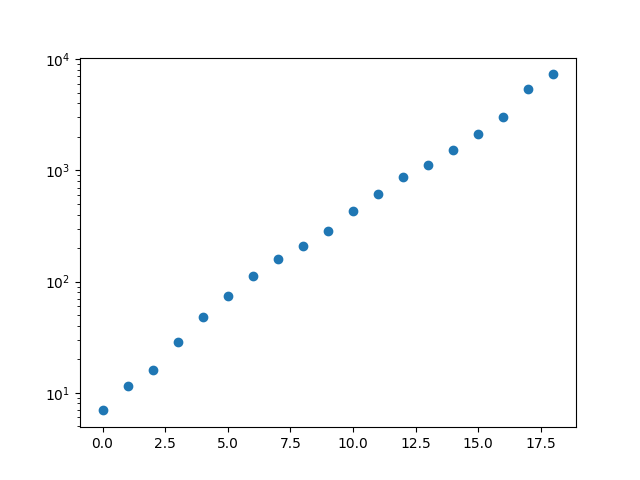

In [12]:
plt.figure()
plt.scatter(list(range(len(df))), df["param_count"])
plt.yscale('log')

# Experiments list

In [13]:
a100_flops = 312 * 1e12
gpu_efficiency = 0.4
a100_gpu_day = a100_flops * gpu_efficiency * 86400  # FLOP produced by one A100 GPU in a day.

In [14]:
a100_gpu_day

1.078272e+19

In [15]:
1e21 / a100_gpu_day

92.74097815764482

In [16]:
# 3e18 = 16hours on one V100 GPU
# 1e21 = 222 GPU-days (V100)
# 1e21 = 93 GPU-days (A100)
compute_budgets = [3e18, 6e18, 1e19, 3e19, 6e19, 1e20, 3e20, 6e20, 1e21]

We start with a full grid on the compute-budgets and model sizes

In [25]:
experiments = [list(row) + [c] for c in compute_budgets for idx, row in df.iterrows()]
experiments = pd.DataFrame(np.array(experiments), columns = list(df.columns) + ["compute"])

In [26]:
# C = 6*N*D (not taking activation-recomputation into account)
# D = C / (6*N)
experiments["training_tokens"] = experiments["compute"] / (6 * experiments["param_count"] * 1e6)

In [27]:
experiments

,num_layer,hidden_size,num_heads,param_count,compute,training_tokens
0,2.0,128.0,2.0,6.933504,3.000000e+18,7.211361e+10
1,4.0,192.0,3.0,11.436800,3.000000e+18,4.371852e+10
2,4.0,256.0,4.0,15.904256,3.000000e+18,3.143813e+10
3,6.0,384.0,6.0,28.878336,3.000000e+18,1.731402e+10
4,8.0,512.0,8.0,47.821824,3.000000e+18,1.045548e+10
...,...,...,...,...,...,...
166,26.0,2304.0,18.0,1514.448896,1.000000e+21,1.100510e+11
167,30.0,2560.0,20.0,2117.992960,1.000000e+21,7.869085e+10
168,36.0,2816.0,22.0,3026.364416,1.000000e+21,5.507158e+10
169,40.0,3584.0,28.0,5360.269312,1.000000e+21,3.109297e+10


In [28]:
total_compute = sum(experiments['compute'])
print(f"Total compute: {total_compute}")

Total compute: 4.007099999999996e+22


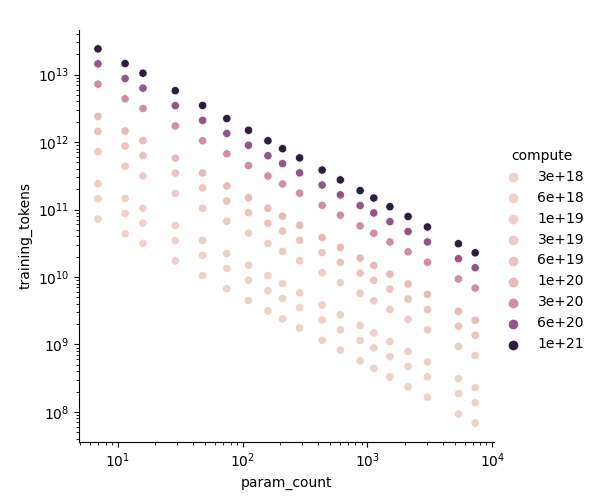

In [29]:
g = sns.relplot(data=experiments, x='param_count', y='training_tokens', hue='compute', legend='full')
g.set(xscale="log")
g.set(yscale="log")
plt.show()

In [30]:
# Remove runs that would train for more than 400B tokens or less than 1B tokens
max_num_tokens = 400e9
min_num_tokens = 1e9
experiments = experiments[experiments["training_tokens"] <= max_num_tokens]
experiments = experiments[experiments["training_tokens"] >= min_num_tokens]

In [31]:
total_compute = sum(experiments['compute'])
print(f"There are now {len(experiments)} experiments to run for a total compute of: {total_compute:.3E} = {total_compute/a100_gpu_day:.1f} A100-gpu-days")

There are now 116 experiments to run for a total compute of: 2.177E+22 = 2019.1 A100-gpu-days


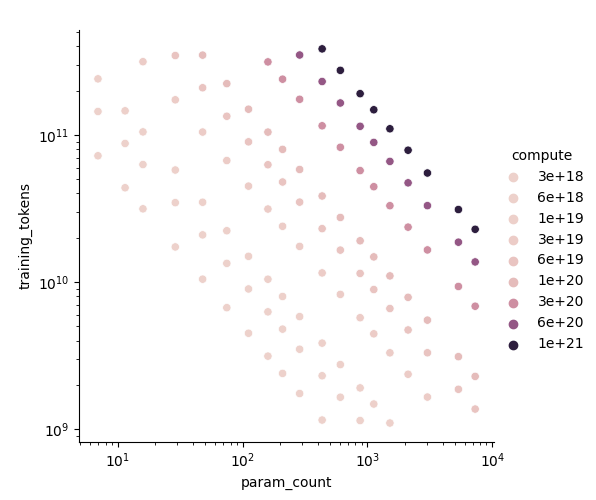

In [32]:
g = sns.relplot(data=experiments, x='param_count', y='training_tokens', hue='compute', legend='full')
g.set(xscale="log")
g.set(yscale="log")
plt.show()

# Set some other hyper-params

In [33]:
def get_batch_size_tokens(param_count):
    if param_count >= 4000:
        return 2**20  # 1M tokens
    else:
        return 2**19  # .5M tokens

def get_learning_rate(param_count):
    if param_count < 400:
        return 3 * 1e-4
    elif param_count < 1500:
        return 2 * 1e-4
    elif param_count < 5000:
        return 1.5 * 1e-4
    else:
        return 1e-4

def get_num_gpu(row):
    if row["compute"] <= 1e19:
        return 2
    elif row["compute"] <= 1e20:
        return 8
    elif row["compute"] <= 3e20:
        return 16
    elif row["compute"] <= 6e20:
        return 32
    else:
        return 32

def get_training_time(row):
    """Return the training time in days"""
    # Total flops/sec
    gpu_flops = gpu_efficiency * a100_flops * row["num_gpu"]
    return row["compute"] / (gpu_flops * 86400)

def get_micro_batch_size(row):
    return row["global_batch_size"] / row["num_gpu"]

def get_training_iters(row):
    return int(row["training_tokens"] / row["batch_size_tokens"])

def get_lr_warmup_iters(row):
    return min(1000, int(row["training_iters"] / 10))

In [34]:
experiments["attention_head_type"] = "multiquery"
experiments["sequence_length"] = 2048
experiments["batch_size_tokens"] = experiments["param_count"].apply(get_batch_size_tokens)
experiments["global_batch_size"] = experiments["batch_size_tokens"] / experiments["sequence_length"]
experiments["learning_rate"] = experiments["param_count"].apply(get_learning_rate)
experiments["num_gpu"] = experiments.apply(get_num_gpu, axis=1)
experiments["training_time"] = experiments.apply(get_training_time, axis=1)
experiments["micro_batch_size"] = experiments.apply(get_micro_batch_size, axis=1)
experiments["training_iters"] = experiments.apply(get_training_iters, axis=1)
experiments["lr_warmup_iters"] = experiments.apply(get_lr_warmup_iters, axis=1)

In [35]:
experiments

,num_layer,hidden_size,num_heads,param_count,compute,training_tokens,attention_head_type,sequence_length,batch_size_tokens,global_batch_size,learning_rate,num_gpu,training_time,micro_batch_size,training_iters,lr_warmup_iters
0,2.0,128.0,2.0,6.933504,3.000000e+18,7.211361e+10,multiquery,2048,524288,256.0,0.00030,2,0.139111,128.0,137545,1000
1,4.0,192.0,3.0,11.436800,3.000000e+18,4.371852e+10,multiquery,2048,524288,256.0,0.00030,2,0.139111,128.0,83386,1000
2,4.0,256.0,4.0,15.904256,3.000000e+18,3.143813e+10,multiquery,2048,524288,256.0,0.00030,2,0.139111,128.0,59963,1000
3,6.0,384.0,6.0,28.878336,3.000000e+18,1.731402e+10,multiquery,2048,524288,256.0,0.00030,2,0.139111,128.0,33023,1000
4,8.0,512.0,8.0,47.821824,3.000000e+18,1.045548e+10,multiquery,2048,524288,256.0,0.00030,2,0.139111,128.0,19942,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,26.0,2304.0,18.0,1514.448896,1.000000e+21,1.100510e+11,multiquery,2048,524288,256.0,0.00015,32,2.898156,8.0,209905,1000
167,30.0,2560.0,20.0,2117.992960,1.000000e+21,7.869085e+10,multiquery,2048,524288,256.0,0.00015,32,2.898156,8.0,150090,1000
168,36.0,2816.0,22.0,3026.364416,1.000000e+21,5.507158e+10,multiquery,2048,524288,256.0,0.00015,32,2.898156,8.0,105040,1000
169,40.0,3584.0,28.0,5360.269312,1.000000e+21,3.109297e+10,multiquery,2048,1048576,512.0,0.00010,32,2.898156,16.0,29652,1000


In [36]:
max(experiments["training_time"])

2.8981555674264006

In [37]:
max(experiments["training_tokens"])

384314857491.8695

In [38]:
csv_data = experiments.to_csv()
print(csv_data)

,num_layer,hidden_size,num_heads,param_count,compute,training_tokens,attention_head_type,sequence_length,batch_size_tokens,global_batch_size,learning_rate,num_gpu,training_time,micro_batch_size,training_iters,lr_warmup_iters
0,2.0,128.0,2.0,6.933504,3e+18,72113609511.1505,multiquery,2048,524288,256.0,0.00030000000000000003,2,0.13911146723646722,128.0,137545,1000
1,4.0,192.0,3.0,11.4368,3e+18,43718522663.68215,multiquery,2048,524288,256.0,0.00030000000000000003,2,0.13911146723646722,128.0,83386,1000
2,4.0,256.0,4.0,15.904255999999998,3e+18,31438125744.45482,multiquery,2048,524288,256.0,0.00030000000000000003,2,0.13911146723646722,128.0,59963,1000
3,6.0,384.0,6.0,28.878335999999997,3e+18,17314016984.91215,multiquery,2048,524288,256.0,0.00030000000000000003,2,0.13911146723646722,128.0,33023,1000
4,8.0,512.0,8.0,47.821824,3e+18,10455477398.770905,multiquery,2048,524288,256.0,0.00030000000000000003,2,0.13911146723646722,128.0,19942,1000
5,10.0,640.0,10.0,74.7008,3e+18,6693368745.716244,mult